In [10]:
#:author: Philipp Steen

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm
import matplotlib.mlab as mlab
import math
import h5py

In [11]:
def picasso_hdf5(df, hdf5_fname, hdf5_oldname, path):
    
    """
    This function recieves a pandas data frame coming from a Picasso .hdf5
    file but that has been modified somehow (e.g. coordinates rotated, 
    groups edited, etc) and formats it to be compatible with Picasso. 
    It also creates the necessary .yaml file.
    
    It is meant to be used in a folder that contains the original Picasso
    .hdf5 file and the .yaml file.
    
    - df: pandas data frame object
    - hdf5_fname: the desired filename for the Picasso-compatible .hdf5 file
    - hdf5_oldname: name of the original Picasso file that was modified
    - path: the absolute path containing the path to the file's folder
    
    Note: include ".hdf5" in the file names
    Warning: the .yaml file is basically a copy of the old one. If important
    information should be added to the new .yaml file this function should be
    modified
    
    """

    labels = list(df.keys())
    df_picasso = df.reindex(columns=labels, fill_value=1)
    locs = df_picasso.to_records(index = False)

    # Saving data
    
    hf = h5py.File(path + hdf5_fname, 'w')
    hf.create_dataset('locs', data=locs)
    hf.close()

    # YAML saver

    yaml_oldname = path + hdf5_oldname.replace('.hdf5', '.yaml')
    yaml_newname = path + hdf5_fname.replace('.hdf5', '.yaml')
    
    yaml_file_info = open(yaml_oldname, 'r')
    yaml_file_data = yaml_file_info.read()
    
    yaml_newfile = open(yaml_newname, 'w')
    yaml_newfile.write(yaml_file_data)
    yaml_newfile.close()   
    
    print('New Picasso-compatible .hdf5 file and .yaml file successfully created.')

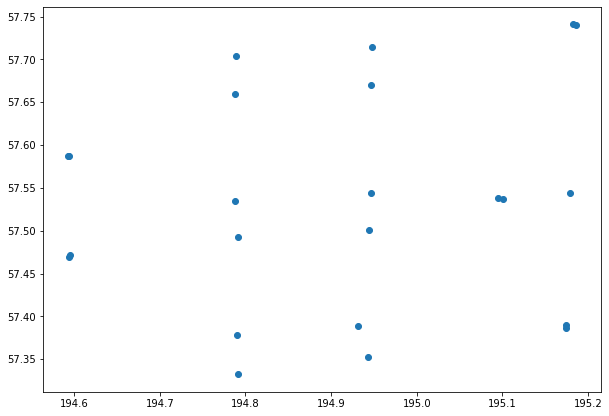

In [5]:
path = "/resi-path.hdf5"
px_size = 130
everything = pd.read_hdf(path, key = 'locs')

everything.y = -1*everything.y #Invert Y coordinates to adjust from Picasso-style to conventional axis direction


#print(df_centers.keys())
n = 10000
px = 130 #in nm

#print(everything)

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    """
    ox, oy = origin
    px, py = point
    
    angle = (math.pi/180)*angle

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy


for index, row in everything.iterrows():
    #print(row["x"], row["y"])
    newx, newy = rotate([0,0], [row["x"], row["y"]], 62)
    everything.loc[index,['x']] = newx
    everything.loc[index,['y']] = newy

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
yolo = ax.plot(everything["x"], everything["y"], "o")
ax.set_aspect('equal')
plt.show()

df_centers = everything

In [6]:
def resample(row, n, px):
    
    """
    Resampling of a cluster center is performed by drawing n samples of a 
    3D Gaussian around the cluster center. The covariance matrix of the 3d 
    Gaussian is defined by the standard error of the mean previously calculated
    for each cluster center and stored in lpx, lpy and lpz columns.

    Parameters
    ----------
    row : row of pandas dataframe (series)
        A row corresponds to one RESI cluster center. 
        The row contains the following columns:  
        'frame', 'x', 'y', 'z', 'photons', 'sx', 'sy', 'bg', 'lpx', 'lpy',
        'lpz', 'group_input', 'n'
        x, y: pixel
        z: nm
        lpx, lpy, lpz: pixel
    n : integer
        The number of points that will be drawn from a 3D gaussian .
    px : integer
        Pixel size in nm

    Returns
    -------
    A dataframe with n+1 rows (n resampled points plus one row for the original
    cluster center). Column keys correspond to the original dataframe row. 
    Each resampled row is a duplicate of the original row except the x, y and z
    value, which were sampled from the Gaussian distribution.
    """

    n = int(row.lpx*1000*n) #Density adjustment for clearer visualization
    
    mean = [row.x, row.y]
    cov = [[row.lpx**2,0],[0,row.lpy**2]]
    x, y = np.random.multivariate_normal(mean, cov, n).T
    # append the cluster center coordinate to the resampled coordinates:
    x = np.append(np.array(row.x),x) 
    y = np.append(np.array(row.y),y)
    
    df = pd.DataFrame({'x': x, 'y': y})
    
    df.insert(0, 'frame', row.frame) # insert frame column before x, y and z columns
    df['photons'] = row.photons
    df['sx'] = row.sx
    df['sy'] = row.sy
    df['bg'] = row.bg
    df['lpx'] = row.lpx
    df['lpy'] = row.lpy
    #df['group_input'] = row.group_input
    df['n'] = row.n

    return df

result = []
for row in df_centers.itertuples():
    print(type(row))
    result.append(resample(row, n, px))
   
result = pd.concat(result, axis = 0, ignore_index = True)

#print(result.shape)
#print(result)

result_nm = result
result_nm.x = result_nm.x*130
result_nm.y = result_nm.y*130

edge_l_x = min(result_nm.x)
edge_l_y = min(result_nm.y)
edge_r_x = max(result_nm.x)
edge_u_y = max(result_nm.y)

result_nm.x = result_nm.x-edge_l_x
result_nm.y = result_nm.y-edge_l_y

<class 'pandas.core.frame.Pandas'>
<class 'pandas.core.frame.Pandas'>
<class 'pandas.core.frame.Pandas'>
<class 'pandas.core.frame.Pandas'>
<class 'pandas.core.frame.Pandas'>
<class 'pandas.core.frame.Pandas'>
<class 'pandas.core.frame.Pandas'>
<class 'pandas.core.frame.Pandas'>
<class 'pandas.core.frame.Pandas'>
<class 'pandas.core.frame.Pandas'>
<class 'pandas.core.frame.Pandas'>
<class 'pandas.core.frame.Pandas'>
<class 'pandas.core.frame.Pandas'>
<class 'pandas.core.frame.Pandas'>
<class 'pandas.core.frame.Pandas'>
<class 'pandas.core.frame.Pandas'>
<class 'pandas.core.frame.Pandas'>
<class 'pandas.core.frame.Pandas'>
<class 'pandas.core.frame.Pandas'>
<class 'pandas.core.frame.Pandas'>
<class 'pandas.core.frame.Pandas'>
<class 'pandas.core.frame.Pandas'>
<class 'pandas.core.frame.Pandas'>


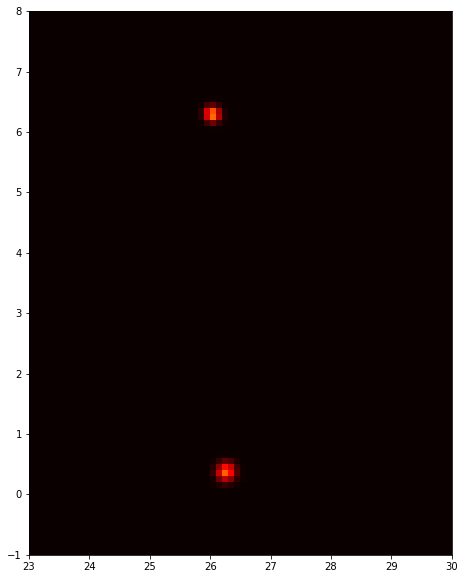

In [7]:
bins=np.arange(min(result_nm.x)-5, max(result_nm.x)+5 + 0.1, 0.1)
fig = plt.figure(figsize=(10, 10))
fig.tight_layout()
ax = fig.add_subplot(111)
hurra = ax.hist2d(result_nm.x, result_nm.y, bins=bins, cmap = "hot")
ax.set_xlim(23, 30)
ax.set_ylim(-1, 8)
ax.set_aspect('equal')
#plt.savefig('5nm_ori_spot43_RESI_zoom.png', transparent=False, dpi=600)
plt.show()


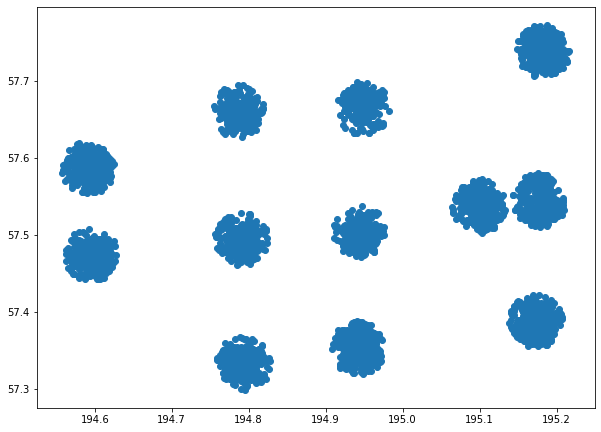

In [13]:
path = "/clustered-data-path.hdf5"

px_size = 130
everything = pd.read_hdf(path, key = 'locs')

everything.y = -1*everything.y #Invert Y coordinates to adjust from Picasso-style to conventional axis direction

for index, row in everything.iterrows():
    #print(row["x"], row["y"])
    newx, newy = rotate([0,0], [row["x"], row["y"]], 62)
    everything.loc[index,['x']] = newx
    everything.loc[index,['y']] = newy

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
yolo = ax.plot(everything["x"], everything["y"], "o")
ax.set_aspect('equal')
plt.show()

In [14]:
picasso_hdf5(everything, "clusters_ROTATED.hdf5", "clusters.hdf5", "parent-folder/")

New Picasso-compatible .hdf5 file and .yaml file successfully created.


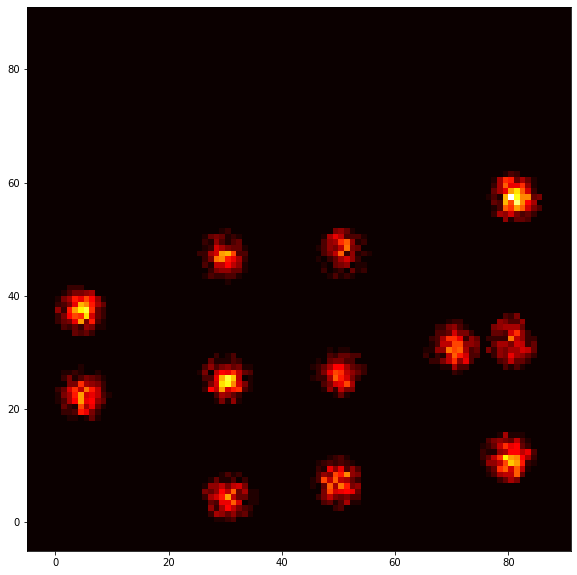

In [6]:
result_nm = everything
result_nm.x = result_nm.x*130
result_nm.y = result_nm.y*130

edge_l_x = min(result_nm.x)
edge_l_y = min(result_nm.y)
edge_r_x = max(result_nm.x)
edge_u_y = max(result_nm.y)

result_nm.x = result_nm.x-edge_l_x
result_nm.y = result_nm.y-edge_l_y

bins=np.arange(min(result_nm.x)-5, max(result_nm.x)+5 + 1., 1.)
fig = plt.figure(figsize=(10, 10))
#fig.tight_layout()
ax = fig.add_subplot(111)
hurra = ax.hist2d(result_nm.x, result_nm.y, bins=bins, cmap = "hot")
ax.set_aspect('equal')
#plt.savefig('5nm_ori_spot43_R3.png', transparent=False, dpi=600)
plt.show()

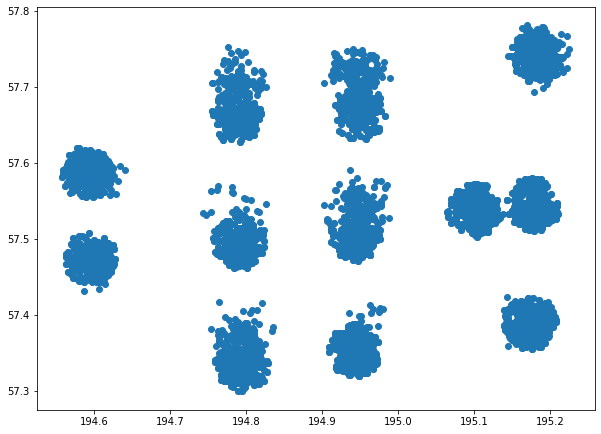

In [15]:
path1 = "/R1-clusters.hdf5"
path2 = "/R3-clusters.hdf5"

px_size = 130
everything1 = pd.read_hdf(path1, key = 'locs')
everything2 = pd.read_hdf(path2, key = 'locs')

everything = pd.concat([everything1, everything2])

everything.y = -1*everything.y #Invert Y coordinates to adjust from Picasso-style to conventional axis direction

for index, row in everything.iterrows():
    #print(row["x"], row["y"])
    newx, newy = rotate([0,0], [row["x"], row["y"]], 62)
    everything.loc[index,['x']] = newx
    everything.loc[index,['y']] = newy

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
yolo = ax.plot(everything["x"], everything["y"], "o")
ax.set_aspect('equal')
plt.show()

In [16]:
picasso_hdf5(everything, "DNA-PAINT-COMBINED_ROTATED.hdf5", "R3_R4_ori0_aligned_ClusterD4.5_20.hdf5", "destination-path/")

New Picasso-compatible .hdf5 file and .yaml file successfully created.


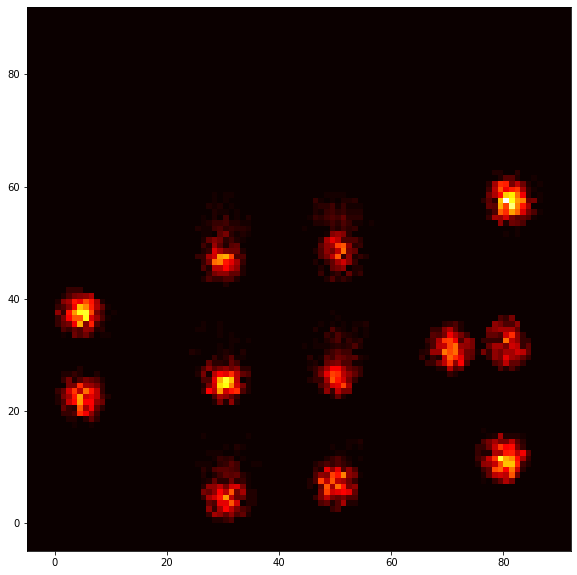

In [8]:
result_nm = everything
result_nm.x = result_nm.x*130
result_nm.y = result_nm.y*130

edge_l_x = min(result_nm.x)
edge_l_y = min(result_nm.y)
edge_r_x = max(result_nm.x)
edge_u_y = max(result_nm.y)

result_nm.x = result_nm.x-edge_l_x
result_nm.y = result_nm.y-edge_l_y

bins=np.arange(min(result_nm.x)-5, max(result_nm.x)+5 + 1., 1.)
fig = plt.figure(figsize=(10, 10))
#fig.tight_layout()
ax = fig.add_subplot(111)
hurra = ax.hist2d(result_nm.x, result_nm.y, bins=bins, cmap = "hot")
ax.set_aspect('equal')
#plt.savefig('5nm_ori_spot43_DNA-PAINT.png', transparent=False, dpi=600)
plt.show()